In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn.functional as F

import numpy as np
import pandas as pd
from PIL import Image
import requests
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [ ]:
# Build the LeNet Architecture

In [4]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(400,120),  #in_features = 16 x5x5 
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)

        )
        
    def forward(self,x): 
        a1=self.feature_extractor(x)
        a1 = torch.flatten(a1,1)
        logits=self.classifier(a1)
        probs = F.softmax(logits, dim=1)
        return logits, probs
    

In [5]:
class LeNetv2(nn.Module):
    
    def __init__(self):
        super(LeNetv2, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),

        )
        
    def forward(self,x): 
        a1=self.feature_extractor(x)
        a1 = torch.flatten(a1,1)
        logits = self.classifier(a1)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [6]:
from torchsummary import summary

In [20]:
# Verify the model with Random input data

In [21]:
x = torch.rand(10,1,32,32).to(DEVICE)

In [22]:
model = LeNet().to(DEVICE)
model(x)[1].shape
summary(model, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [23]:
modelv2 = LeNetv2().to(DEVICE)
modelv2(x)[1].shape
summary(modelv2, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              ReLU-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [24]:
# Train Model on MNIST Dataset

In [63]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [64]:
# Helper Functions

In [65]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn-v0_8-whitegrid')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [66]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [67]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [68]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [69]:
# define transforms
train_transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [70]:
# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=train_transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=test_transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [71]:
torch.manual_seed(RANDOM_SEED)

model = LeNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [72]:
# Model training

In [73]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

17:00:15 --- Epoch: 0	Train loss: 0.2441	Valid loss: 0.0886	Train accuracy: 96.96	Valid accuracy: 97.22
17:01:19 --- Epoch: 1	Train loss: 0.0792	Valid loss: 0.0628	Train accuracy: 98.20	Valid accuracy: 97.96
17:02:31 --- Epoch: 2	Train loss: 0.0546	Valid loss: 0.0492	Train accuracy: 98.71	Valid accuracy: 98.48
17:03:38 --- Epoch: 3	Train loss: 0.0436	Valid loss: 0.0418	Train accuracy: 99.01	Valid accuracy: 98.69
17:04:46 --- Epoch: 4	Train loss: 0.0348	Valid loss: 0.0392	Train accuracy: 99.18	Valid accuracy: 98.70
17:06:04 --- Epoch: 5	Train loss: 0.0280	Valid loss: 0.0408	Train accuracy: 99.27	Valid accuracy: 98.86
17:07:25 --- Epoch: 6	Train loss: 0.0245	Valid loss: 0.0336	Train accuracy: 99.49	Valid accuracy: 98.96
17:08:37 --- Epoch: 7	Train loss: 0.0218	Valid loss: 0.0332	Train accuracy: 99.50	Valid accuracy: 98.92
17:09:56 --- Epoch: 8	Train loss: 0.0177	Valid loss: 0.0336	Train accuracy: 99.50	Valid accuracy: 99.04
17:11:16 --- Epoch: 9	Train loss: 0.0160	Valid loss: 0.0488	Trai

C:\Users\T3500\AppData\Local\Temp\ipykernel_113988\1422163134.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


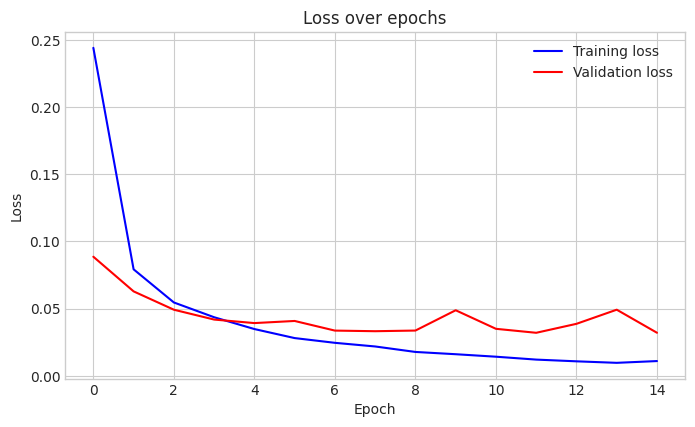

In [74]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

In [75]:
# Make Predictions using the Trained Model

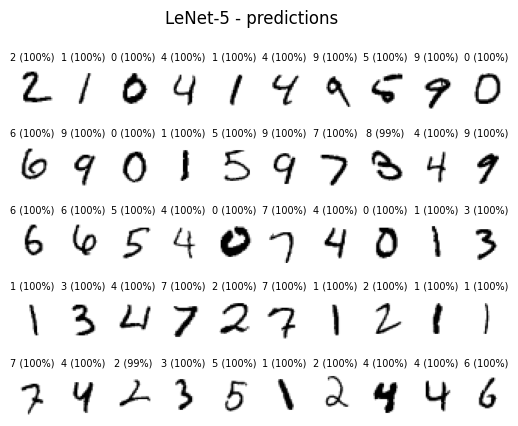

In [77]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0).to(DEVICE))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [78]:
img_url = 'https://thumb.ac-illust.com/ba/ba1cd719cf2d80c3703685fbf02f0def_t.jpeg'
test_img = Image.open(requests.get(img_url, stream = True).raw)

In [79]:
test_imgT = test_transforms(test_img)

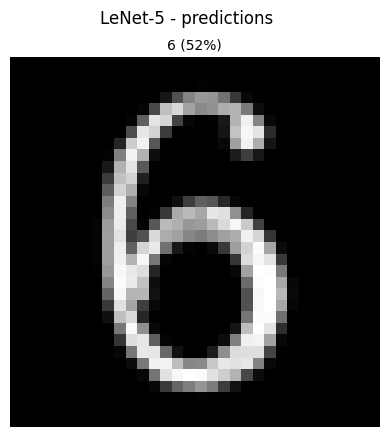

In [81]:
ROW_IMG = 1
N_ROWS = 1

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_imgT.permute(1,2,0), cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_imgT.unsqueeze(0).to(DEVICE))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=10)
fig.suptitle('LeNet-5 - predictions');

In [82]:
for i,p in enumerate(probs.squeeze(0)):
    print(f"Probability of given digit being {i} is {p*100:.0f}%")
print(f"\nMaximum Probability observed for: ")
print(f'Digit: {torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)')

Probability of given digit being 0 is 31%
Probability of given digit being 1 is 0%
Probability of given digit being 2 is 0%
Probability of given digit being 3 is 9%
Probability of given digit being 4 is 0%
Probability of given digit being 5 is 3%
Probability of given digit being 6 is 52%
Probability of given digit being 7 is 0%
Probability of given digit being 8 is 4%
Probability of given digit being 9 is 0%

Maximum Probability observed for: 
Digit: 6 (52%)


In [83]:
top3_preds = torch.topk(probs, 3)

In [84]:
top3_preds

torch.return_types.topk(
values=tensor([[0.5245, 0.3127, 0.0870]], device='cuda:0'),
indices=tensor([[6, 0, 3]], device='cuda:0'))

In [85]:
# Gradio App for sketching digits

In [86]:
# gradio_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((32, 32)),
#     transforms.Grayscale(),
#     transforms.ToTensor()
# ])

In [87]:
# def predict_sketch(sketch):
#     test_imgT = gradio_transforms(sketch)
#     with torch.no_grad():
#         model.eval()
#         _, probs = model(test_imgT.unsqueeze(0))
#         print(torch.topk(probs, 3))
#         _, prediction = torch.max(probs, dim=1)

#     return prediction[0].item()

In [88]:
# import gradio as gr
# iface = gr.Interface(fn=predict_sketch, inputs='sketchpad', outputs='label').launch(share=True)